In [100]:
# 读取数据
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
train_data1=train_data.copy()
train_data1[skew_index]=log_data
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005])

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


数据概览，分析异常值

In [101]:
# 概览
train_data.describe()



,Default,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [102]:
#重复值
print(train_data.duplicated().value_counts())
print(train_data.duplicated().value_counts())


False    149391
True        609
dtype: int64
False    149391
True        609
dtype: int64


**查看变量的分位数等信息**


In [103]:
train_data.describe().transpose()[['min', '25%', '50%', '75%', 'max']]

,min,25%,50%,75%,max
Default,0.0,0.000000,0.000000,0.000000,1.0
Balance_r,0.0,0.029867,0.154181,0.559046,50708.0
Age,0.0,41.000000,52.000000,63.000000,109.0
Worse_1m,0.0,0.000000,0.000000,0.000000,98.0
Debt_r,0.0,0.175074,0.366508,0.868254,329664.0
Income,0.0,3400.000000,5400.000000,8249.000000,3008750.0
Credit_num,0.0,5.000000,8.000000,11.000000,58.0
Worse_3m,0.0,0.000000,0.000000,0.000000,98.0
Estate_num,0.0,0.000000,1.000000,2.000000,54.0
Worse_2m,0.0,0.000000,0.000000,0.000000,98.0


定义两个画图的函数 方便观察分布时对各个变量复用

In [104]:

import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif
#直方图
def plot_distributions_discrete(feature):

    _, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(train_data[feature], kde=True, label='Train',stat='density',
                 discrete=True, color='steelblue', alpha=0.6, ax=axes[0])
    sns.histplot(test_data[feature], kde=True, label='Test',stat='density',
                 discrete=True, color='gold', alpha=0.25, ax=axes[0])
    axes[0].legend()
    axes[0].set_title('Distr Train set vs Distr Test set')

    sns.boxplot(x='Default', y=feature, data=train_data, ax=axes[1], palette=['gold', 'tan'])

    X = train_data[[feature]].dropna()
    MI = mutual_info_classif(X, train_data.loc[X.index, 'Default'], discrete_features=True,
                             random_state=0)
    axes[1].set_title('Distribution depending on the Default\n-> MI Score : ' + str(round(MI[0], 7)))

    plt.suptitle('"{}" distributions'.format(feature), y=1.15);



In [105]:
# 曲线图
def plot_distributions_continuous(feature):

    _, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.kdeplot(train_data[feature].apply(np.log1p), label='Train',
                color='steelblue', alpha=0.5, shade=True, edgecolor='k', ax=axes[0])
    sns.kdeplot(test_data[feature].apply(np.log1p), label='Test',
                color='gold', alpha=0.3, shade=True, edgecolor='k', ax=axes[0])

    axes[0].legend()
    axes[0].set_title('Distr Train set vs Distr Test set')
    axes[0].set_xlabel('log-{}'.format(feature))

    sns.boxplot(x='Default', y=train_data[feature],
                data=train_data,orient='v', ax=axes[1], palette=['gold', 'tan'])

    X = train_data[[feature]].dropna()
    MI = mutual_info_classif(X, train_data.loc[X.index, 'Default'], random_state=0)
    axes[1].set_title('Distribution depending on the Default\n-> MI Score : ' + str(round(MI[0], 7)))

    plt.suptitle('"{}" distributions'.format(feature), y=1.15);

age异常值处理

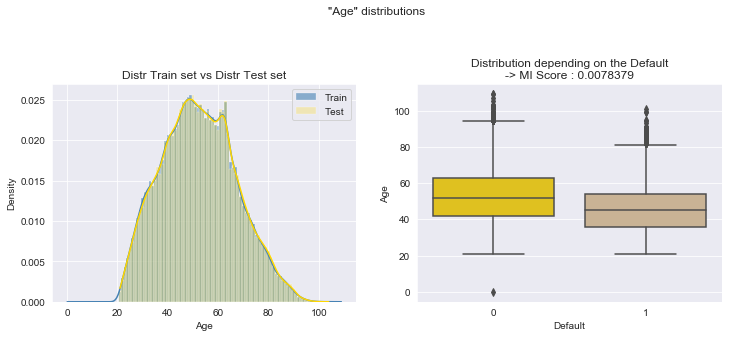

In [106]:
plot_distributions_discrete('Age')

未成年人不能办信用卡

In [107]:
train_data[train_data["Age"]<20]

,Default,Balance_r,Age,Worse_1m,Debt_r,Income,Credit_num,Worse_3m,Estate_num,Worse_2m,Family_num
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


所以上面一条记录是有误的，删去

In [108]:
train_data = train_data[train_data["Age"]>=20]

DebtRatio

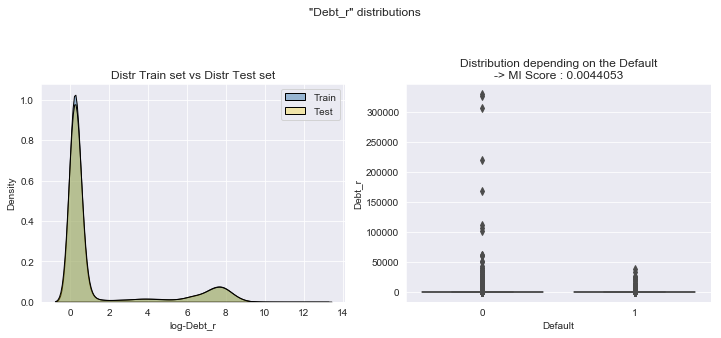

In [109]:
plot_distributions_continuous('Debt_r')

MonthlyIncome

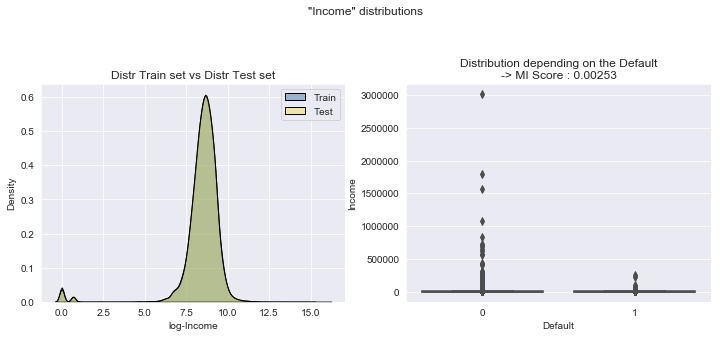

In [110]:
plot_distributions_continuous('Income')

NumberOfDependents

E:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:605: RuntimeWarning: invalid value encountered in log
  log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())


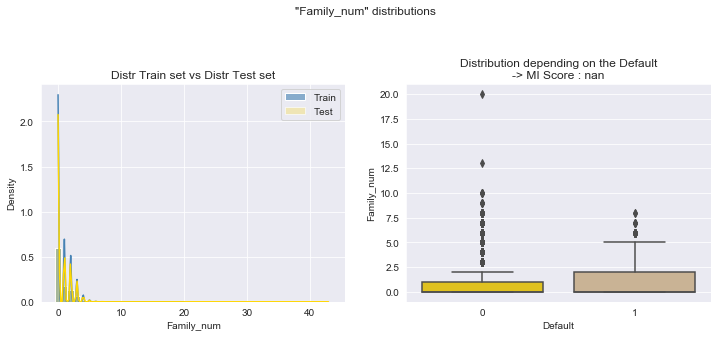

In [111]:
plot_distributions_discrete('Family_num')

RevolvingUtilizationOfUnsecuredLines

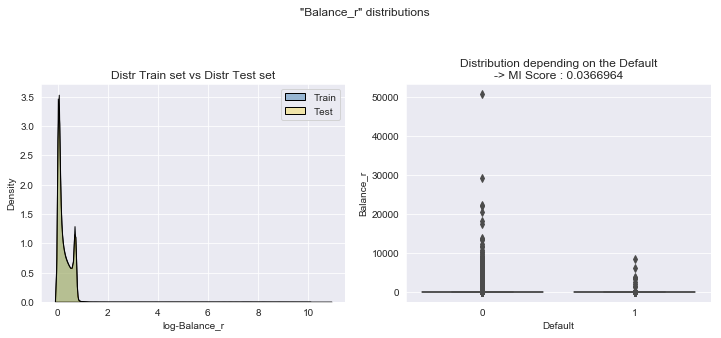

In [112]:
plot_distributions_continuous('Balance_r')

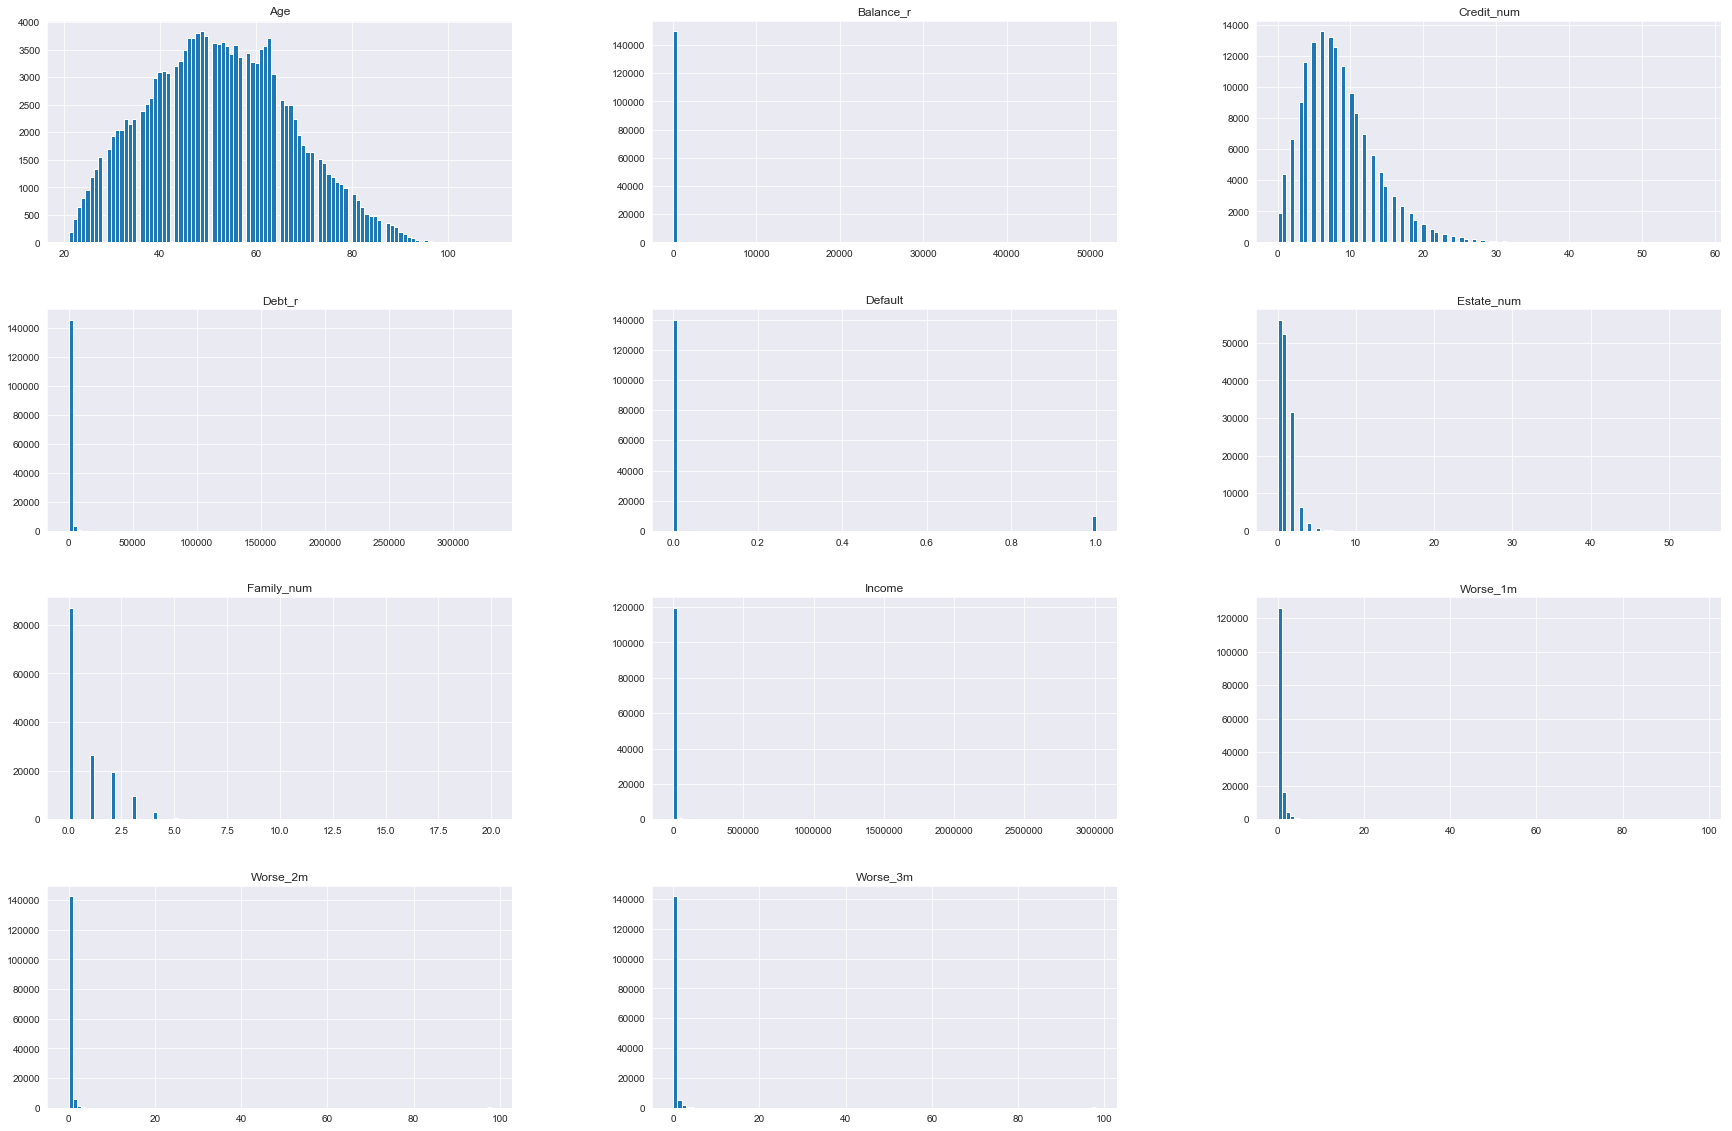

In [113]:
train_data.hist(bins=100, figsize=(30,20))
plt.show()